<a href="https://colab.research.google.com/github/SergioPGJunior/Reconhecimento-de-emocoes-na-fala-com-audios-em-Portugues/blob/main/projeto_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade librosa

In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, svm
from matplotlib import pyplot as plt

path = "/content/drive/MyDrive/Banco de Dados/"

In [ ]:
def matriz_mfcc(y,fs, n_mfcc=12,delta=False,delta2=False):

  mfcc = librosa.feature.mfcc(y, fs, n_mfcc=n_mfcc)
  
  if delta == True & delta2 == True:
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc,order=2)
    parametros = np.concatenate((mfcc, mfcc_delta,mfcc_delta2))
    
  elif delta == True:
    mfcc_delta = librosa.feature.delta(mfcc)
    parametros = np.concatenate((mfcc, mfcc_delta))

  elif delta2 == True:
    mfcc_delta2 = librosa.feature.delta(mfcc,order=2)
    parametros = np.concatenate((mfcc, mfcc_delta2))

  else:
    parametros = mfcc

  return parametros.tolist()

def parametros_globais(vetor_parametros):

  media = np.mean(vetor_parametros,axis=1).transpose()
  mediana = np.median(vetor_parametros,axis=1).transpose()
  maximo = np.amax(vetor_parametros,axis=1).transpose()
  minimo = np.amin(vetor_parametros,axis=1).transpose()
  std = np.std(vetor_parametros,axis=1).transpose()

  return np.concatenate((media, mediana, maximo, minimo, std)).tolist()

In [ ]:
clara = "/content/drive/MyDrive/Banco de Dados/Clara/Felicidade/Felicidade 01.wav"

y, fs = librosa.load(clara)

mfcc8 = matriz_mfcc(y,fs, n_mfcc=8,delta=False,delta2=False)
mfcc12 = matriz_mfcc(y,fs, n_mfcc=12,delta=False,delta2=False)
mfcc20 = matriz_mfcc(y,fs, n_mfcc=20,delta=False,delta2=False)

print([row[0] for row in mfcc8])
print(mfcc12)
print(mfcc20)

[-456.2925720214844, 91.72008514404297, -10.384869575500488, 13.543874740600586, 10.19154167175293, -8.532122611999512, 2.7281951904296875, 4.4170451164245605]
[[-456.2925720214844, -448.6684875488281, -455.868896484375, -484.1012878417969, -507.4930114746094, -521.1417236328125, -528.9569702148438, -481.5699157714844, -332.1857604980469, -244.25778198242188, -217.55406188964844, -227.0355224609375, -240.01278686523438, -235.00558471679688, -246.46136474609375, -209.39013671875, -187.52423095703125, -223.3110809326172, -264.5067443847656, -311.6488342285156, -364.7528076171875, -415.82391357421875, -387.2636413574219, -247.6917724609375, -173.7246856689453, -160.22854614257812, -190.75514221191406, -165.15370178222656, -120.65215301513672, -76.39613342285156, -58.60456085205078, -67.12555694580078, -87.98126220703125, -136.560791015625, -198.56532287597656, -153.37841796875, -132.40267944335938, -184.2646484375, -212.515380859375, -163.68008422851562, -141.73202514648438, -156.55094909

In [ ]:
fs

22050

In [ ]:
actors = ['Clara', 'Getúlio', 'Marcos', 'Mauro', 'Nívea', 'Patricia', 'Renato', 'Stella']
emotions = ['Felicidade', 'Neutra', 'Raiva', 'Tristeza']

columns= ['actor','emotion','filename','parametros']
df = pd.DataFrame(columns = columns)

for actor in actors:
  for emotion in emotions: 
    files = os.scandir(path + actor + '/' + emotion)
    for file in files:
      try:
        y, fs = librosa.load(file)
        # yt, index = librosa.effects.trim(y, top_db=38)
        mfcc = matriz_mfcc(y,fs,20,delta=False,delta2=False)
        # mfcc = matriz_mfcc(yt,fs,20,delta=True,delta2=False)
        parametros = parametros_globais(mfcc)
        values = [actor, emotion, file, parametros]
        df = df.append(dict(zip(columns, values)),True)
      except:
        print('O arquivo {}, do ator {}, com a emoção {} não pode ser lido'.format(file,actor,emotion))
      
#Gera a coluna alvo
df['target'] = 0
df.loc[df['emotion'] =='Neutra','target'] = 1
df.loc[df['emotion']=='Raiva','target'] = 2
df.loc[df['emotion']=='Tristeza','target'] = 3


O arquivo <DirEntry '.DS_Store'>, do ator Clara, com a emoção Raiva não pode ser lido
O arquivo <DirEntry '._.DS_Store'>, do ator Clara, com a emoção Raiva não pode ser lido
O arquivo <DirEntry '.DS_Store'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry '._Felicidade 01.wav'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry '._.DS_Store'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry '._Felicidade 08.wav'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry '._Felicidade 09.wav'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry '._Felicidade 05.wav'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry '._Felicidade 10.wav'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry '._Felicidade 03.wav'>, do ator Getúlio, com a emoção Felicidade não pode ser lido
O arquivo <DirEntry 

In [ ]:
df.to_csv('emoUERJ_20.csv',index=False)

In [ ]:
felicidade = df[df['emotion']=='Felicidade']
media_parametros = []
for i in range(100):
  media = np.mean([row[i] for row in felicidade['parametros']])
  media_parametros.append(media)

felicidade_media = [media_parametros[j] for j in range(0,96,5)] 
felicidade_mediana = [media_parametros[j] for j in range(1,97,5)] 
felicidade_maximo = [media_parametros[j] for j in range(2,98,5)] 
felicidade_minimo = [media_parametros[j] for j in range(3,99,5)]
felicidade_desvio = [media_parametros[j] for j in range(4,100,5)]

neutra = df[df['emotion']=='Neutra']
media_parametros = []
for i in range(100):
  media = np.mean([row[i] for row in neutra['parametros']])
  media_parametros.append(media)

neutra_media = [media_parametros[j] for j in range(0,96,5)] 
neutra_mediana = [media_parametros[j] for j in range(1,97,5)] 
neutra_maximo = [media_parametros[j] for j in range(2,98,5)] 
neutra_minimo = [media_parametros[j] for j in range(3,99,5)]
neutra_desvio = [media_parametros[j] for j in range(4,100,5)]

raiva = df[df['emotion']=='Raiva']
media_parametros = []
for i in range(100):
  media = np.mean([row[i] for row in raiva['parametros']])
  media_parametros.append(media)

raiva_media = [media_parametros[j] for j in range(0,96,5)] 
raiva_mediana = [media_parametros[j] for j in range(1,97,5)] 
raiva_maximo = [media_parametros[j] for j in range(2,98,5)] 
raiva_minimo = [media_parametros[j] for j in range(3,99,5)]
raiva_desvio = [media_parametros[j] for j in range(4,100,5)]

tristeza = df[df['emotion']=='Tristeza']
media_parametros = []
for i in range(100):
  media = np.mean([row[i] for row in tristeza['parametros']])
  media_parametros.append(media)

tristeza_media = [media_parametros[j] for j in range(0,96,5)] 
tristeza_mediana = [media_parametros[j] for j in range(1,97,5)] 
tristeza_maximo = [media_parametros[j] for j in range(2,98,5)] 
tristeza_minimo = [media_parametros[j] for j in range(3,99,5)]
tristeza_desvio = [media_parametros[j] for j in range(4,100,5)]

plt.rcParams['figure.figsize'] = [13,5]

plt.plot(felicidade_media,'o-')
plt.plot(neutra_media,'o-')
plt.plot(raiva_media,'o-')
plt.plot(tristeza_media,'o-')
plt.grid()
plt.xticks(range(21))
plt.figure()
plt.plot(felicidade_mediana,'o-')
plt.plot(neutra_mediana,'o-')
plt.plot(raiva_mediana,'o-')
plt.plot(tristeza_mediana,'o-')
plt.grid()
plt.xticks(range(21))
plt.figure()


plt.show()

In [ ]:
df = pd.read_csv('emoUERJ_20.csv')

In [ ]:
#Gera a matriz de entrada apropriada para o Keras
X = np.array(df['parametros'].tolist())

In [ ]:
np.shape(X)

(377, 100)

In [ ]:
np.shape(df[df['emotion'] == 'Tristeza'])

(100, 5)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca.fit(X)

X = pca.transform(X)

ratio = pca.explained_variance_ratio_

print(pca.explained_variance_ratio_)
print(sum(ratio))

#print(pca.singular_values_)

[0.23314919 0.10680788 0.08223254 0.05821187 0.04726709 0.04227671
 0.03794785 0.0321146  0.02889911 0.02711593 0.01961692 0.01793768
 0.01686692 0.01534941 0.01401174 0.01237955 0.01197326 0.01044147
 0.01002863 0.0096013  0.00902562 0.00887257 0.00823848 0.00765258
 0.00743368 0.00676798 0.00648048 0.00600092 0.00583949 0.00568767
 0.00539183 0.00496921 0.00474348 0.00451588 0.00415482 0.00397233
 0.00354186 0.00344259 0.00327871 0.00310808]
0.9473478849817606


In [ ]:
dicio = {0:len(df[df['target'] == 0])/len(df),1:len(df[df['target'] == 1])/len(df), 2:len(df[df['target'] == 2])/len(df), 3:len(df[df['target'] == 3])/len(df)}

In [ ]:
#Classificação com SVM

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, df['target'],
                                                    test_size=0.3)
resultado = []
for i in range(10):
  clf = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf'))
  clf.fit(X_train,y_train)
  #print(clf.classes_)
  scores = cross_val_score(clf, X, df['target'], cv=5)
  med = scores.sum()/len(scores)
  resultado.append(med)

sum(resultado)/10
# clf.fit(X_train,y_train)
# predicted = clf.predict(X_test)

# print(metrics.accuracy_score(y_test, predicted))
# print(metrics.confusion_matrix(y_test, predicted))

0.6288421052631579

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)


print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10.0, 'gamma': 0.01} with a score of 0.90


In [ ]:
predicted = grid.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

0.8859649122807017
[[26  3  6  0]
 [ 1 23  0  1]
 [ 2  0 24  0]
 [ 0  0  0 28]]


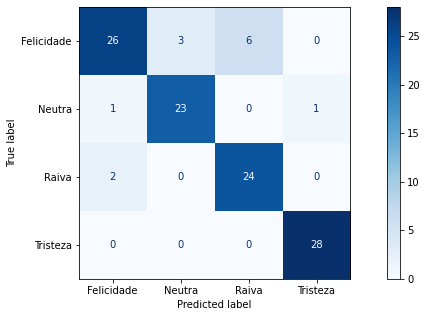

In [ ]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Felicidade','Neutra', 'Raiva', 'Tristeza']

plot_confusion_matrix(grid, X_test, y_test,display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Classificação com Naive Bayes Gaussiano

from sklearn.naive_bayes import GaussianNB

clf = make_pipeline(StandardScaler(), GaussianNB())
scores = cross_val_score(clf, X, df['target'], cv=3)
scores.sum()/len(scores)

0.673798941798942

0.41228070175438597
[[20  0  1  2]
 [ 9  0  0 15]
 [19  0  0  8]
 [13  0  0 27]]


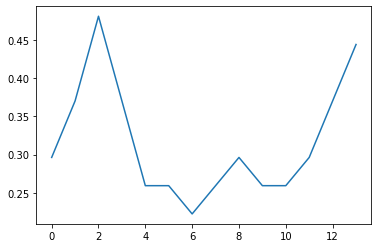

In [ ]:
#Classificação com Rede Neural

from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt

# resultado = []
# for i in range(10):
#   clf =  MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=50,learning_rate_init=0.01,early_stopping=True, max_iter=500)
#   scores = cross_val_score(clf, X, df['target'], cv=3)
#   med = scores.sum()/len(scores)
#   resultado.append(med)

# sum(resultado)/10

clf =  MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=50,
                     validation_fraction=0.1,early_stopping=True, 
                     max_iter=500).fit(X_train,y_train)
#plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)


# clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

print(metrics.accuracy_score(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

In [ ]:
#Classificação com Random Forest

from sklearn.ensemble import RandomForestClassifier

resultado = []

for i in range(10):
  clf = RandomForestClassifier(max_depth=15,oob_score=True)
  #clf = RandomForestClassifier(max_depth=15)
  scores = cross_val_score(clf, X_train, y_train, cv=5)
  med = sum(scores)/5
  resultado.append(med)
sum(resultado)/10

0.8145573294629898

In [ ]:
depth_range = range(5,31,5)
n_estimators_range = range(10, 101, 10)
param_grid = dict(max_depth=depth_range, n_estimators=n_estimators_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)


print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'max_depth': 25, 'n_estimators': 60} with a score of 0.84


In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.01956272, 0.03066859, 0.04528818, 0.05721798, 0.07022314,
        0.08344455, 0.10536804, 0.10929279, 0.12263656, 0.13498888,
        0.01480989, 0.02899885, 0.04336996, 0.05731478, 0.07280331,
        0.08756504, 0.10464082, 0.11823053, 0.13365874, 0.14429507,
        0.01507936, 0.02904773, 0.04308763, 0.05775986, 0.07500782,
        0.08687239, 0.10395455, 0.11490312, 0.12843661, 0.14544849,
        0.01493244, 0.02896705, 0.04383349, 0.05746636, 0.07536278,
        0.09704013, 0.1050848 , 0.11549349, 0.13446059, 0.14378409,
        0.01491389, 0.02999096, 0.04353514, 0.05779409, 0.07542472,
        0.08567042, 0.10380745, 0.11514893, 0.12805934, 0.1546361 ,
        0.01514273, 0.02989535, 0.04390655, 0.0575954 , 0.0739327 ,
        0.08720522, 0.10064301, 0.11697969, 0.13467999, 0.14363742]),
 'mean_score_time': array([0.0016417 , 0.00204525, 0.0027204 , 0.00334425, 0.00396075,
        0.00479097, 0.0054338 , 0.00587525, 0.00628266, 0.00669713,
        0.

In [ ]:
predicted = grid.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))
#print(metrics.confusion_matrix(y_test, predicted))

0.8070175438596491


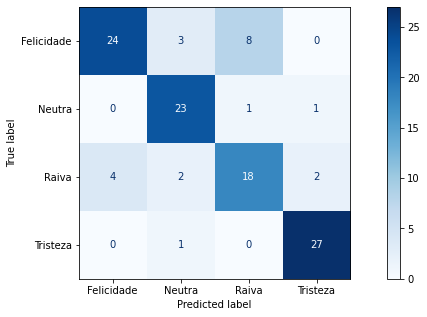

In [ ]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Felicidade','Neutra', 'Raiva', 'Tristeza']

plot_confusion_matrix(grid, X_test, y_test,display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Ajusta o vetor com os labels para utilizar no keras
from sklearn.preprocessing import MultiLabelBinarizer
Y = df['target'].apply(lambda x:[x])

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
#Classificação com Rede Neural usando Keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)

y_train = MultiLabelBinarizer().fit_transform(y_train)

# create model
model = Sequential()
model.add(Dense(100, input_dim=np.shape(X_train)[1], activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(4, activation='softmax'))

# Compile model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

# Fit the model
history = model.fit(X_train, y_train,validation_split=0.3, epochs=500, batch_size=10, verbose=0, callbacks=[es, mc])

In [ ]:
#Plota as curvas de treinamento

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid()
plt.show()
plt.figure()

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()


In [ ]:
#Calcula a acurácia dos dados de teste e a matriz confusão
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(X_test), axis=-1)

yhat_classes = [[i] for i in yhat_classes]

yhat_classes = MultiLabelBinarizer().fit_transform(yhat_classes)
y_test = MultiLabelBinarizer().fit_transform(y_test)

# The predictions are returned in a two-dimensional array, with one row for each example in the test dataset and one column for the prediction.
# The scikit-learn metrics API expects a 1D array of actual and predicted values for comparison, therefore, we must reduce the 2D prediction arrays to 1D arrays
# reduce to 1d array
# yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

matrix =confusion_matrix(
    y_test.argmax(axis=1), yhat_classes.argmax(axis=1))

print(matrix)


In [ ]:
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5, shuffle=True)
y = df.target
accuracy = []
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print('train_index: ', train_index)
    #print('test_index: ', test_index)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    result = accuracy_score(y_test, yhat)
    accuracy.append(result)
print(sum(accuracy)/5)

In [ ]:
parametros_felicidade = df.parametros[df.target == 0]
data_felicidade =[]
for parametros in parametros_felicidade:
  data_felicidade.append(parametros)
coef_felicidade = np.mean(data_felicidade,axis=0)

In [ ]:
parametros_neutra = df.parametros[df.target == 1]
data_neutra =[]
for parametros in parametros_neutra:
  data_neutra.append(parametros)
coef_neutra = np.mean(data_neutra,axis=0)

In [ ]:
parametros_raiva = df.parametros[df.target == 2]
data_raiva =[]
for parametros in parametros_raiva:
  data_raiva.append(parametros)
coef_raiva = np.mean(data_raiva,axis=0)

In [ ]:
parametros_tristeza = df.parametros[df.target == 3]
data_tristeza =[]
for parametros in parametros_tristeza:
  data_tristeza.append(parametros)
coef_tristeza = np.mean(data_tristeza,axis=0)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [13,5]

plt.plot(range(1,20),coef_felicidade[1:20],'bo-',label='Felicidade')
plt.plot(range(1,20),coef_neutra[1:20],'go-',label='Neutra')
plt.plot(range(1,20),coef_raiva[1:20],'ro-',label='Raiva')
plt.plot(range(1,20),coef_tristeza[1:20],'ko-',label='Tristeza')
plt.xticks(range(1,20))
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(range(20,41),coef_felicidade[20:41],'bo-',label='Felicidade')
plt.plot(range(20,41),coef_neutra[20:41],'go-',label='Neutra')
plt.plot(range(20,41),coef_raiva[20:41],'ro-',label='Raiva')
plt.plot(range(20,41),coef_tristeza[20:41],'ko-',label='Tristeza')
plt.xticks(range(20,41))
plt.legend()
plt.grid()
plt.show()

In [ ]:
a = range(42,48)
plt.plot(a,coef_felicidade[a],'bo-',label='Felicidade')
plt.plot(a,coef_neutra[a],'go-',label='Neutra')
plt.plot(a,coef_raiva[a],'ro-',label='Raiva')
plt.plot(a,coef_tristeza[a],'ko-',label='Tristeza')
plt.xticks(a)
plt.legend()
plt.grid()
plt.show()